In [1]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.misc as smp
from PIL import Image
import numba
from numba import njit, vectorize, cuda
from timeit import default_timer as timer
from pylab import imshow, show
from tqdm import tqdm
import math

In [49]:
resolution = (1920,1080)
J_c = (-0.75, 0)
J_z = 68227450827.50151

h2 = 1.5  # height factor of the incoming light
angle = -45  # incoming direction of light
v = np.exp(1j*angle*2*math.pi/360)

R = 100

@njit
def Mandelbrot(x, y, max_iterations):
    c = complex(x,y)
    dz = complex (0,0)
    z = 0.0j

    for iterations in range(max_iterations):
        if (z.real*z.real + z.imag*z.imag) >= (R*R):
            u = z/dz
            u = u/abs(u)  # normal vector: (u.re,u.im,1) 
            t = u.real*v.real + u.imag*v.imag + h2  # dot product with the incoming light
            t = t/(1+h2)  # rescale so that t does not get bigger than 1
            if t<0: 
                t=0
            return t*255
        
        dz = dz*2*z +1
        z = z*z + c
        
    return 0

mandel_gpu = cuda.jit(device=True)(Mandelbrot)

@cuda.jit
def render_kernel(centre_x, centre_y, zoom, max_iter, rendergrid):
    xmin = centre_x - (3.5/(2*zoom))
    xmax = centre_x + (3.5/(2*zoom))
    ymin = centre_y - (2/(2*zoom))
    ymax = centre_y + (2/(2*zoom))

    pixel_width = (xmax-xmin)/resolution[0]
    pixel_height = (ymax-ymin)/resolution[1]
    
    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x
    gridY = cuda.gridDim.y * cuda.blockDim.y

    for i in range(startX, resolution[0], gridX):
        real = xmin + i*pixel_width
        for j in range(startY, resolution[1], gridY):
            imaginary = ymin + j*pixel_height
            colour = mandel_gpu(real,imaginary, max_iter)
            rendergrid[j,i] = colour

Mandelbrot created on GPU in 0.861378 s


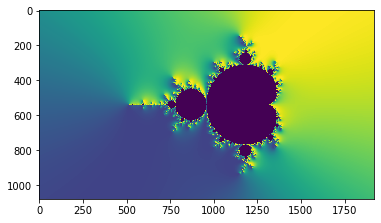

In [51]:
grendergrid = np.zeros((resolution[1], resolution[0]), dtype = np.uint8)
blockdim = (32,8)
griddim = (32,16)

start = timer()
d_rendergrid = cuda.to_device(grendergrid)
render_kernel[griddim, blockdim](J_c[0], J_c[1], 0.65, 10000, d_rendergrid) 
d_rendergrid.to_host()
dt = timer() - start

print("Mandelbrot created on GPU in %f s" % dt)
Image.fromarray( grendergrid ).save('ANormal_Mandelbrot.png')
imshow(grendergrid)
show()

In [4]:
frames = []
total_framecount = 2700
cm = plt.get_cmap('inferno')

for i in tqdm(range(total_framecount)):
    grendergrid = np.zeros((resolution[1], resolution[0]), dtype = np.uint8)
    d_rendergrid = cuda.to_device(grendergrid)
    render_kernel[griddim, blockdim](J_c[0], J_c[1], 2**(i/60) , 10000, d_rendergrid) 
    d_rendergrid.to_host()
    #Image.fromarray( grendergrid ).save(str(i)+'_November.png')
    colored = cm( grendergrid )
    img = Image.fromarray((colored[:, :, :3] * 255).astype(np.uint8)) # Create a PIL image
    img.save(str(i)+'_November.png')
    frames.append(img)

100%|████████████████████████████████████████████████████████████████████████████| 2700/2700 [1:43:13<00:00,  2.29s/it]


In [ ]:
frames[0].save('Normal_inferno_November.gif', format='GIF', append_images=frames[1:], save_all=True, duration=175, loop=0)

In [ ]:
frames = []
cm = plt.get_cmap('inferno')
total_framecount = 1
for i in tqdm(range(total_framecount)):
    grendergrid = np.zeros((resolution[1], resolution[0]), dtype = np.uint8)
    d_rendergrid = cuda.to_device(grendergrid)
    render_kernel[griddim, blockdim](J_c[0], J_c[1], 0 , 10000, d_rendergrid) 
    d_rendergrid.to_host()
    img = Image.fromarray( grendergrid )
    #colored = cm( grendergrid )
    #img = Image.fromarray((colored[:, :, :3] * 255).astype(np.uint8)) # Create a PIL image
    frames.append(img)


In [ ]:
frames[0].save('Normal_BW_Zoomzoom.png')